# Stack multiple STAC items from Earth Search by Element 84 STAC API

This notebook shows an example how to stack multiple tiles of Sentinel-2 L2A data from Earth Search by Element 84 STAC API. The stacking is performed using [odc-stac](https://odc-stac.readthedocs.io/en/latest/), which allows to perform a mosaicking of multiple tiles measured on the same solar day, shown at the end of this notebook. 

### Setup
In order to run this notebook you need to install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac). You may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) directly from the git repository by cloning the repository, directing into `xcube-stac`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-stac
pip install .
```

Note that [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store
from xcube_stac._utils import reproject_bbox

CPU times: user 4.47 s, sys: 420 ms, total: 4.89 s
Wall time: 3.03 s


First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). We assign the url of the STAC catalog and set `stack_mode=True`.

In [2]:
%%time
store = new_data_store(
    "stac", url="https://earth-search.aws.element84.com/v1", stack_mode=True
)

CPU times: user 85 ms, sys: 19.2 ms, total: 104 ms
Wall time: 732 ms


In the stacking mode, the data IDs are the collection IDs within the STAC catalog. The data IDs can be listed using the following code.

In [3]:
%%time
store.list_data_ids()

CPU times: user 18.3 ms, sys: 4.94 ms, total: 23.2 ms
Wall time: 775 ms


['sentinel-2-pre-c1-l2a',
 'cop-dem-glo-30',
 'naip',
 'cop-dem-glo-90',
 'landsat-c2-l2',
 'sentinel-2-l2a',
 'sentinel-2-l1c',
 'sentinel-2-c1-l2a',
 'sentinel-1-grd']

Next, we open the data and assign `data_id` to `"sentinel-2-l2a"` to select Sentinel-2 L2A data. We set the bounding box to cover the greater Hamburg area and the time range to July 2020.

In [4]:
bbox = [9.1, 53.1, 10.7, 54]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

In [5]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2020-07-15", "2020-08-01"],
    crs=crs_target,
    spatial_res=20,
    asset_names=["red", "green", "blue"],
    apply_scaling=True,
    open_params_dataset_geotiff=dict(tile_size=(1024, 1024)),
)
ds

Stack tiles along time axis.: 100%|█| 11/11 [01:44<00:00,  9.53s/i

CPU times: user 8.92 s, sys: 360 ms, total: 9.28 s
Wall time: 1min 59s


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, y: 5073, x: 5237)
Coordinates:
  * y        (y) float64 41kB 5.985e+06 5.985e+06 ... 5.883e+06 5.883e+06
  * x        (x) float64 42kB 5.067e+05 5.067e+05 ... 6.114e+05 6.114e+05
  * time     (time) datetime64[ns] 88B 2020-07-15T12:26:01.621000 ... 2020-07...
Data variables:
    blue     (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green    (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red      (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    stac_catalog_url:  https://earth-search.aws.element84.com/v1
    stac_item_ids:     {'2020-07-15T12:26:01.621000': ['S2B_32UPE_20200715_1_...

We can plot a tile of the red band for a given timestamp as an example. Note that the bounding box encompasses multiple tiles, where mosaicking is applied. 

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/dask/array/chunk.py:139: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)


CPU times: user 44.7 s, sys: 3.58 s, total: 48.3 s
Wall time: 4min 26s


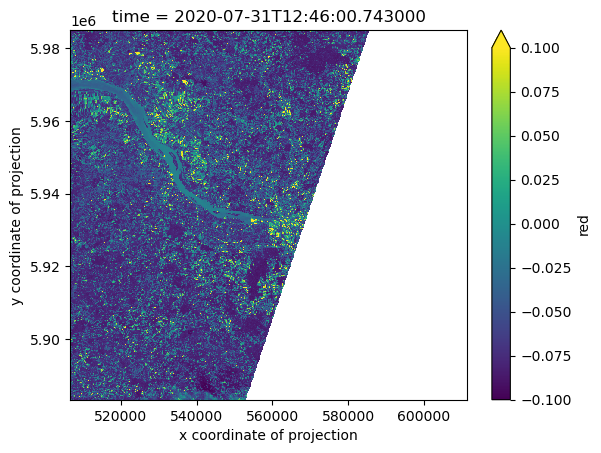

In [6]:
%%time
ds.red.isel(time=-1)[::10, ::10].plot(vmin=-0.1, vmax=0.1)